In [1]:
!pwd

/home/ec2-user/SageMaker


In [12]:
!aws s3 cp s3://pet-images-20230129070812/PetImages PetImages --recursive

download: s3://pet-images-20230129070812/PetImages/Cat/0.jpg to PetImages/Cat/0.jpg    
download: s3://pet-images-20230129070812/PetImages/Cat/10002.jpg to PetImages/Cat/10002.jpg
download: s3://pet-images-20230129070812/PetImages/Cat/1.jpg to PetImages/Cat/1.jpg    
download: s3://pet-images-20230129070812/PetImages/Cat/100.jpg to PetImages/Cat/100.jpg 
download: s3://pet-images-20230129070812/PetImages/Cat/1000.jpg to PetImages/Cat/1000.jpg
download: s3://pet-images-20230129070812/PetImages/Cat/10001.jpg to PetImages/Cat/10001.jpg
download: s3://pet-images-20230129070812/PetImages/Cat/10.jpg to PetImages/Cat/10.jpg 
download: s3://pet-images-20230129070812/PetImages/Cat/10009.jpg to PetImages/Cat/10009.jpg
download: s3://pet-images-20230129070812/PetImages/Cat/10008.jpg to PetImages/Cat/10008.jpg
download: s3://pet-images-20230129070812/PetImages/Cat/10005.jpg to PetImages/Cat/10005.jpg
download: s3://pet-images-20230129070812/PetImages/Cat/10014.jpg to PetImages/Cat/10014.jpg
downlo

In [13]:
!ls PetImages/

Cat  Dog


In [14]:
!ls PetImages/Cat | wc -l

12501


In [15]:
!ls PetImages/Dog | wc -l

12501


In [16]:
import os
import random
import pathlib
import shutil
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [19]:
# Distinct image classes
img_classes = ['cat', 'dog']

# Folders for training, testing, and validation subsets
dir_data  = pathlib.Path.cwd().joinpath('data')
dir_train = dir_data.joinpath('train')
dir_valid = dir_data.joinpath('validation')
dir_test  = dir_data.joinpath('test')

# Train/Test/Validation split config
pct_train = 0.8
pct_valid = 0.1
pct_test = 0.1

# display dir
display(f'dir_data is {dir_data}') 
display(f'dir_train is {dir_train}') 
display(f'dir_valid is {dir_valid}') 
display(f'dir_test is {dir_test}') 
display(type(dir_test))

'dir_data is /home/ec2-user/SageMaker/data'

'dir_train is /home/ec2-user/SageMaker/data/train'

'dir_valid is /home/ec2-user/SageMaker/data/validation'

'dir_test is /home/ec2-user/SageMaker/data/test'

pathlib.PosixPath

# Directory structure

In [21]:
def setup_folder_structure() -> None:
    # Create base folders if they don't exist
    if not dir_data.exists():  dir_data.mkdir()
    if not dir_train.exists(): dir_train.mkdir()
    if not dir_valid.exists(): dir_valid.mkdir()
    if not dir_test.exists():  dir_test.mkdir()
    
    # Create subfolders for each class
    for cls in img_classes:
        if not dir_train.joinpath(cls).exists(): dir_train.joinpath(cls).mkdir()
        if not dir_valid.joinpath(cls).exists(): dir_valid.joinpath(cls).mkdir()
        if not dir_test.joinpath(cls).exists():  dir_test.joinpath(cls).mkdir()
        
    # Print the directory structure
    # Credits - https://stackoverflow.com/questions/3455625/linux-command-to-print-directory-structure-in-the-form-of-a-tree
    dir_str = os.system('''ls -R data | grep ":$" | sed -e 's/:$//' -e 's/[^-][^\/]*\//--/g' -e 's/^/   /' -e 's/-/|/' ''')
    print(dir_str)
    return

In [22]:
setup_folder_structure()

   data
   |-test
   |---cat
   |---dog
   |-train
   |---cat
   |---dog
   |-validation
   |---cat
   |---dog
0


# Train/Test/Validation split

In [23]:
def train_test_validation_split(src_folder: pathlib.PosixPath, class_name: str) -> dict:
    # For tracking
    n_train, n_valid, n_test = 0, 0, 0
    
    # Random seed for reproducibility
    random.seed(42)
    
    # Iterate over every image
    for file in src_folder.iterdir():
        img_name = str(file).split('/')[-1]
        
        # Make sure it's JPG
        if file.suffix == '.jpg':
            # Generate a random number
            x = random.random()
            
            # Where should the image go?
            tgt_dir = ''
            
            # .80 or below
            if x <= pct_train:  
                tgt_dir = 'train'
                n_train += 1
                
            # Between .80 and .90
            elif pct_train < x <= (pct_train + pct_valid):  
                tgt_dir = 'validation'
                n_valid += 1
                
            # Above .90
            else:  
                tgt_dir = 'test'
                n_test += 1
                
            # Copy the image
            shutil.copy(
                src=file,
                # data/<train|valid|test>/<cat\dog>/<something>.jpg
                dst=f'{str(dir_data)}/{tgt_dir}/{class_name}/{img_name}'
            )
            
    return {
        'source': str(src_folder),
        'target': str(dir_data),
        'n_train': n_train,
        'n_validaiton': n_valid,
        'n_test': n_test
    }

In [24]:
%%time

train_test_validation_split(
    src_folder=pathlib.Path.cwd().joinpath('PetImages/Cat'),
    class_name='cat'
)

CPU times: user 558 ms, sys: 805 ms, total: 1.36 s
Wall time: 1.93 s


{'source': '/home/ec2-user/SageMaker/PetImages/Cat',
 'target': '/home/ec2-user/SageMaker/data',
 'n_train': 10016,
 'n_validaiton': 1239,
 'n_test': 1245}

In [25]:
%%time

train_test_validation_split(
    src_folder=pathlib.Path.cwd().joinpath('PetImages/Dog'),
    class_name='dog'
)

CPU times: user 590 ms, sys: 819 ms, total: 1.41 s
Wall time: 1.77 s


{'source': '/home/ec2-user/SageMaker/PetImages/Dog',
 'target': '/home/ec2-user/SageMaker/data',
 'n_train': 10016,
 'n_validaiton': 1239,
 'n_test': 1245}

# Visualizng images

In [26]:
def plot_random_sample(img_dir: pathlib.PosixPath) -> None:
    # How many images we're showing
    n = 10
    # Get absolute paths to these N images
    imgs = random.sample(list(img_dir.iterdir()), n)
    
    # Make sure num_row * num_col = n
    num_row = 2
    num_col = 5 

    # Create a figure
    fig, axes = plt.subplots(num_row, num_col, figsize=(3.5 * num_col, 3 * num_row))
    # For every image
    for i in range(num_row * num_col):
        # Read the image
        img = plt.imread(str(imgs[i]))
        # Display the image
        ax = axes[i // num_col, i % num_col]
        ax.imshow(img)
        # Set title as <train|test|validation>/<cat\dog>/<img_name>.jpg
        ax.set_title('/'.join(str(imgs[i]).split('/')[-3:]))

    plt.tight_layout()
    plt.show()
    return

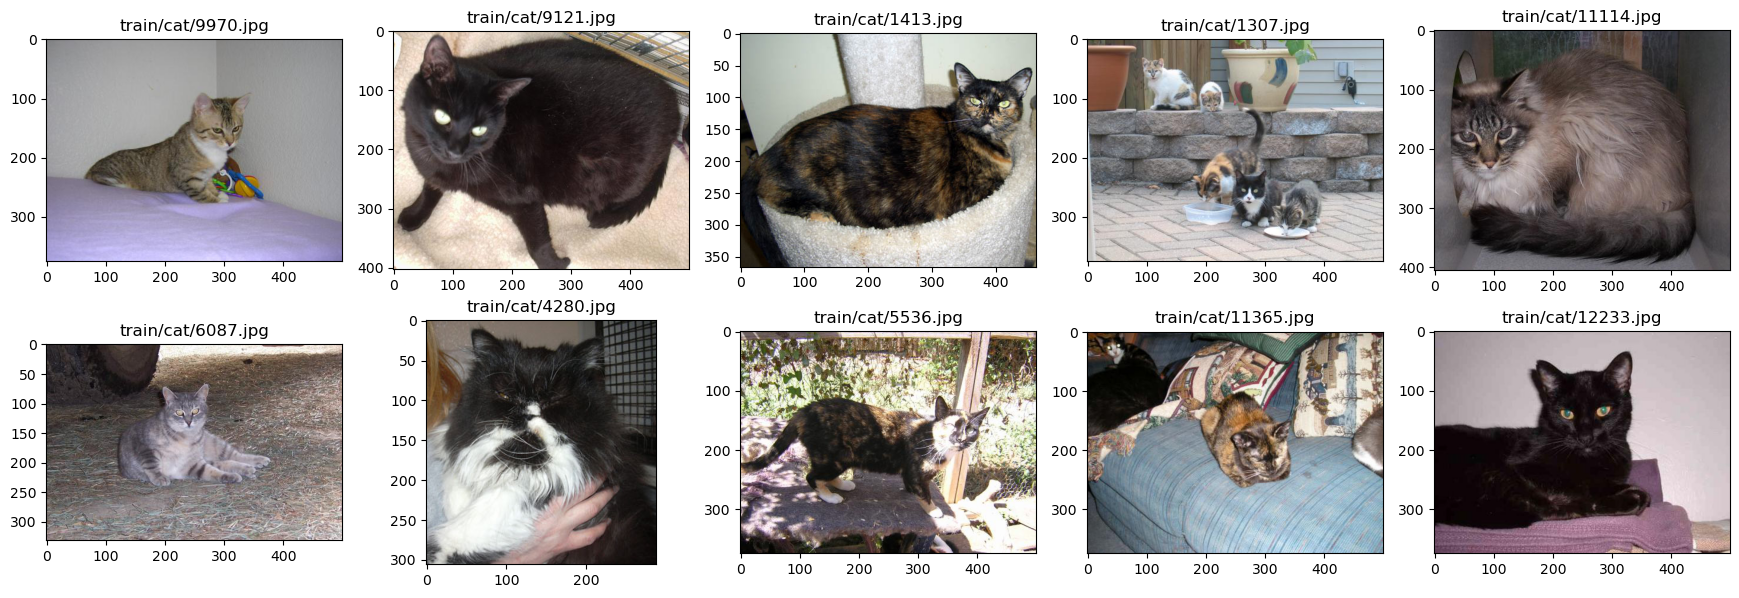

In [27]:
plot_random_sample(img_dir=pathlib.Path().cwd().joinpath('data/train/cat'))

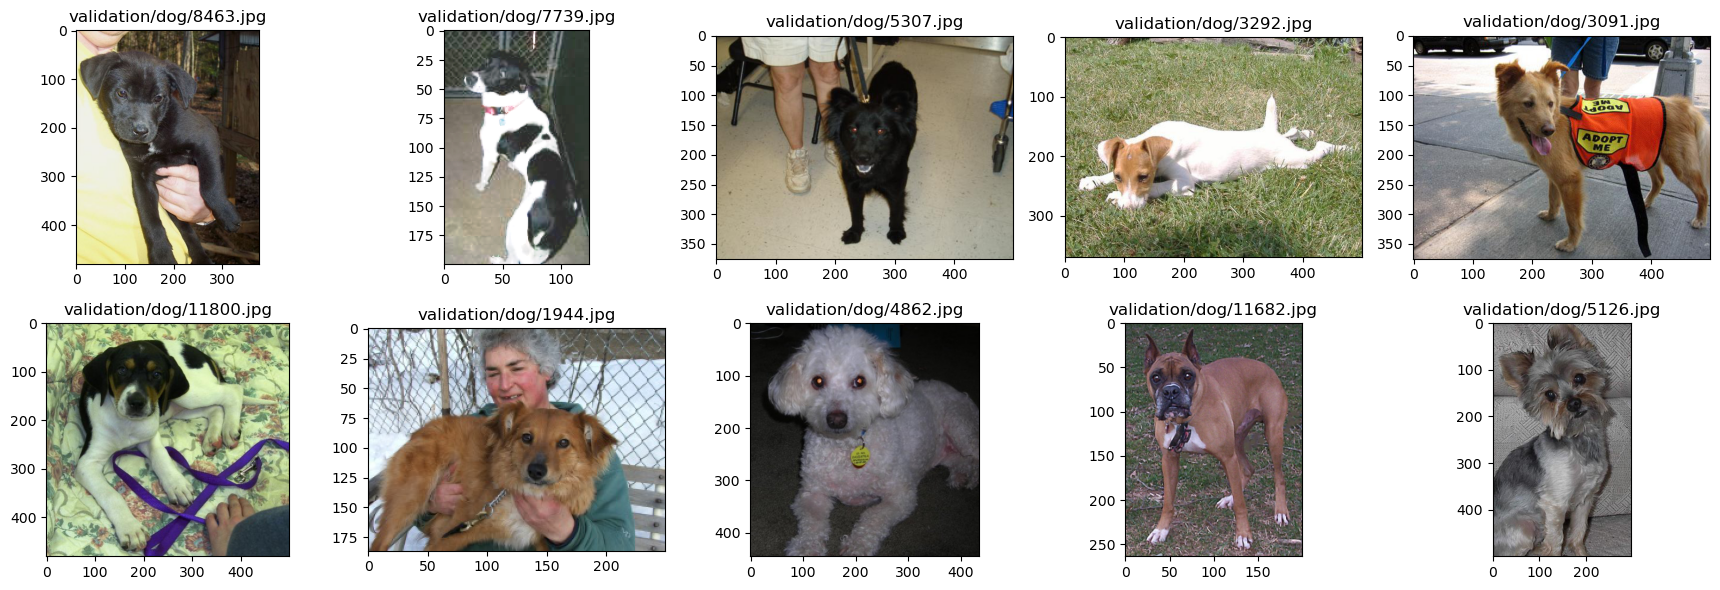

In [28]:
plot_random_sample(img_dir=pathlib.Path().cwd().joinpath('data/validation/dog'))